original task is regression (predicting critical_temp, a continuous variable). so, to use Logistic Regression:

let’s turn critical_temp into classes like:

Class 0 → Low-temperature superconductors

Class 1 → High-temperature superconductors

critical_temp ≥ 75K is "high-temp" (Class 1), and below that is Class 0

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt


In [12]:
df = pd.read_csv("superconductivty+data/train.csv")
df

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence,critical_temp
0,4,88.944468,57.862692,66.361592,36.116612,1.181795,1.062396,122.90607,31.794921,51.968828,...,2.257143,2.213364,2.219783,1.368922,1.066221,1,1.085714,0.433013,0.437059,29.00
1,5,92.729214,58.518416,73.132787,36.396602,1.449309,1.057755,122.90607,36.161939,47.094633,...,2.257143,1.888175,2.210679,1.557113,1.047221,2,1.128571,0.632456,0.468606,26.00
2,4,88.944468,57.885242,66.361592,36.122509,1.181795,0.975980,122.90607,35.741099,51.968828,...,2.271429,2.213364,2.232679,1.368922,1.029175,1,1.114286,0.433013,0.444697,19.00
3,4,88.944468,57.873967,66.361592,36.119560,1.181795,1.022291,122.90607,33.768010,51.968828,...,2.264286,2.213364,2.226222,1.368922,1.048834,1,1.100000,0.433013,0.440952,22.00
4,4,88.944468,57.840143,66.361592,36.110716,1.181795,1.129224,122.90607,27.848743,51.968828,...,2.242857,2.213364,2.206963,1.368922,1.096052,1,1.057143,0.433013,0.428809,23.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21258,4,106.957877,53.095769,82.515384,43.135565,1.177145,1.254119,146.88130,15.504479,65.764081,...,3.555556,3.223710,3.519911,1.377820,0.913658,1,2.168889,0.433013,0.496904,2.44
21259,5,92.266740,49.021367,64.812662,32.867748,1.323287,1.571630,188.38390,7.353333,69.232655,...,2.047619,2.168944,2.038991,1.594167,1.337246,1,0.904762,0.400000,0.212959,122.10
21260,2,99.663190,95.609104,99.433882,95.464320,0.690847,0.530198,13.51362,53.041104,6.756810,...,4.800000,4.472136,4.781762,0.686962,0.450561,1,3.200000,0.500000,0.400000,1.98
21261,2,99.663190,97.095602,99.433882,96.901083,0.690847,0.640883,13.51362,31.115202,6.756810,...,4.690000,4.472136,4.665819,0.686962,0.577601,1,2.210000,0.500000,0.462493,1.84


In [13]:
threshold = df['critical_temp'].median()
print(f"Median Tc: {threshold:.2f} K")


Median Tc: 20.00 K


In [14]:
df['high_temp_superconductor'] = (df['critical_temp'] >= threshold).astype(int)

X = df.drop(columns=['critical_temp', 'high_temp_superconductor'])
y = df['high_temp_superconductor']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [15]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [16]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000)

In [17]:
y_pred = logreg.predict(X_test_scaled)
y_proba = logreg.predict_proba(X_test_scaled)[:, 1]

# Basic metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9019515636021632

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.86      0.90      2118
           1       0.87      0.94      0.91      2135

    accuracy                           0.90      4253
   macro avg       0.90      0.90      0.90      4253
weighted avg       0.90      0.90      0.90      4253



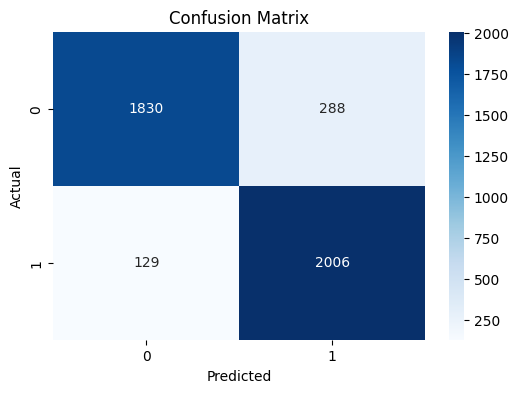

In [18]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


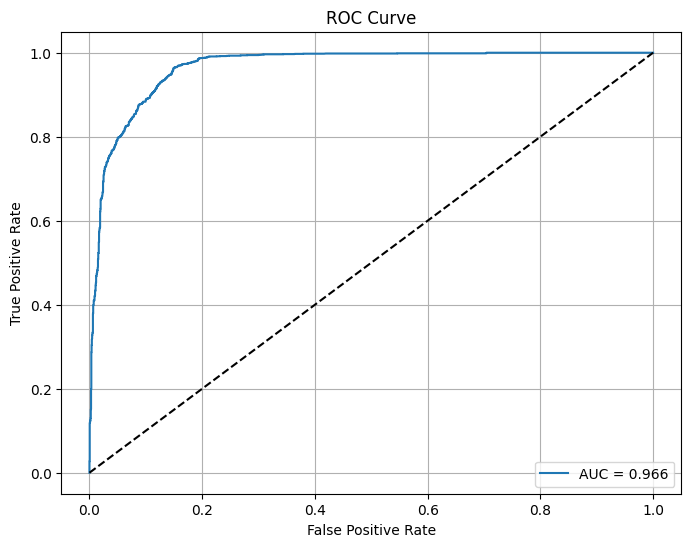

In [19]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.3f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

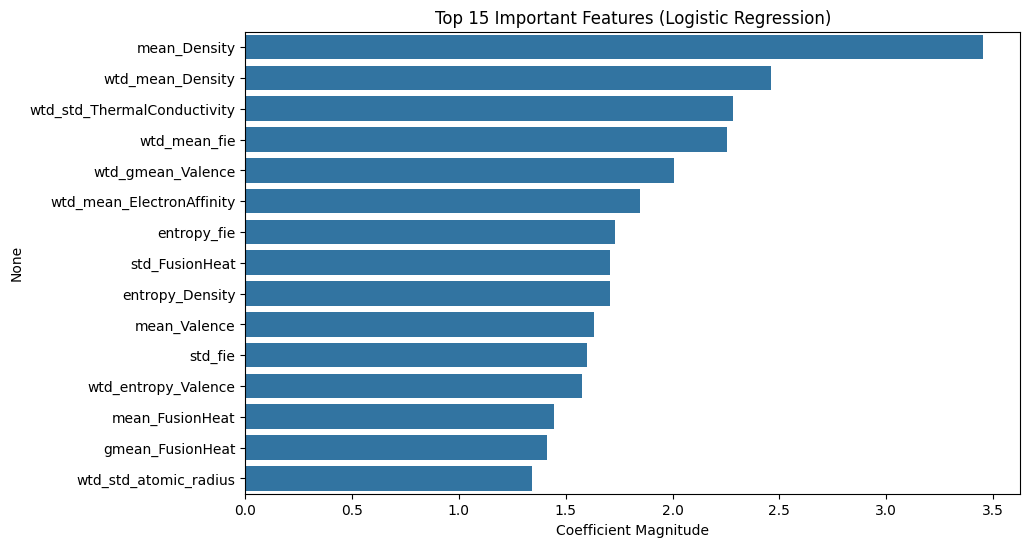

In [20]:
importance = pd.Series(logreg.coef_[0], index=X.columns)
top_feats = importance.abs().sort_values(ascending=False).head(15)

plt.figure(figsize=(10,6))
sns.barplot(x=top_feats.values, y=top_feats.index)
plt.title("Top 15 Important Features (Logistic Regression)")
plt.xlabel("Coefficient Magnitude")
plt.show()

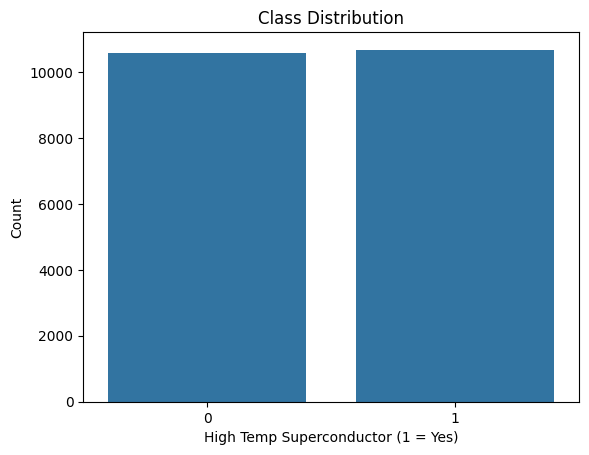

In [21]:
sns.countplot(x=y)
plt.title("Class Distribution")
plt.xlabel("High Temp Superconductor (1 = Yes)")
plt.ylabel("Count")
plt.show()

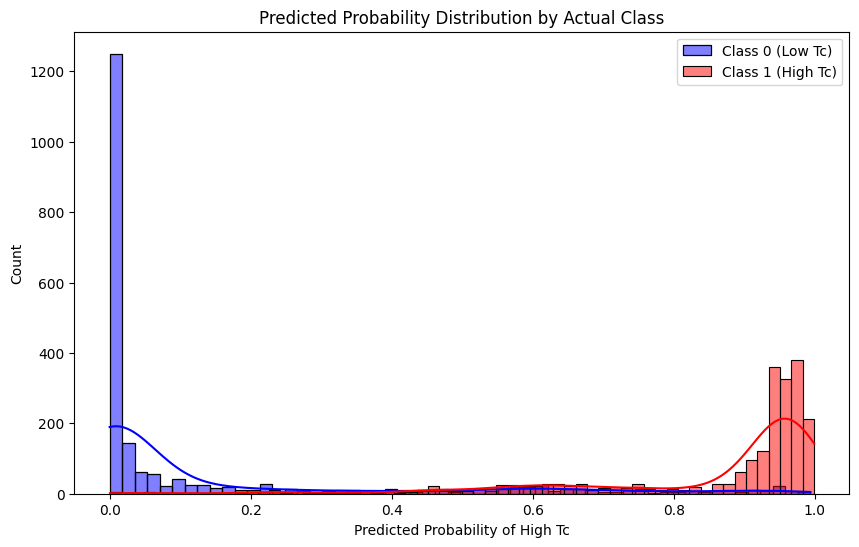

In [22]:
plt.figure(figsize=(10,6))
sns.histplot(y_proba[y_test == 0], color='blue', label='Class 0 (Low Tc)', kde=True)
sns.histplot(y_proba[y_test == 1], color='red', label='Class 1 (High Tc)', kde=True)
plt.title("Predicted Probability Distribution by Actual Class")
plt.xlabel("Predicted Probability of High Tc")
plt.legend()
plt.show()


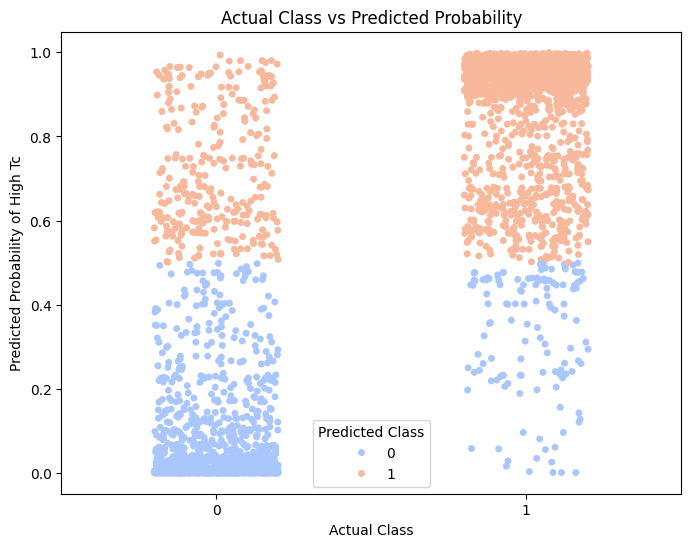

In [23]:
plt.figure(figsize=(8,6))
sns.stripplot(x=y_test, y=y_proba, hue=y_pred, jitter=0.2, palette='coolwarm')
plt.title('Actual Class vs Predicted Probability')
plt.xlabel('Actual Class')
plt.ylabel('Predicted Probability of High Tc')
plt.legend(title="Predicted Class")
plt.show()


In [ ]:
# this was for binary classification


# lets try for multiclass

In [24]:
df['Tc_class_3'] = pd.qcut(df['critical_temp'], q=3, labels=[0, 1, 2])  # 0 = Low, 1 = Mid, 2 = High


In [25]:
X_mc = df.drop(columns=['critical_temp', 'Tc_class_3'])  
y_mc = df['Tc_class_3']

/var/folders/cq/0dymnn6d1xddkd6449rh4s8r0000gn/T/ipykernel_29439/928830947.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['Tc_class_3'], palette='Set2')


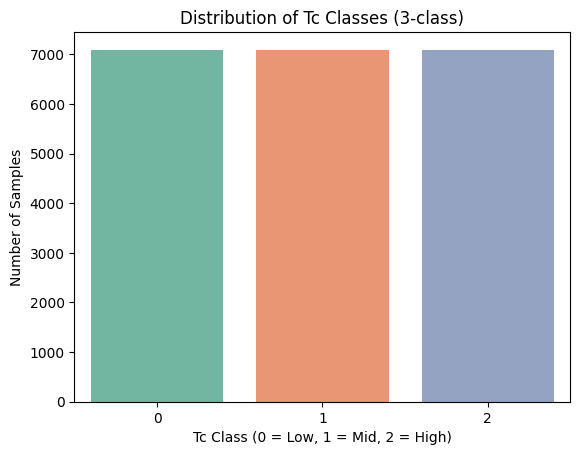

In [28]:
sns.countplot(x=df['Tc_class_3'], palette='Set2')
plt.title("Distribution of Tc Classes (3-class)")
plt.xlabel("Tc Class (0 = Low, 1 = Mid, 2 = High)")
plt.ylabel("Number of Samples")
plt.show()


In [30]:
X_train_mc, X_test_mc, y_train_mc, y_test_mc = train_test_split(X_mc, y_mc, test_size=0.2, stratify=y_mc, random_state=42)

scaler_mc = StandardScaler()
X_train_mc_scaled = scaler_mc.fit_transform(X_train_mc)
X_test_mc_scaled = scaler_mc.transform(X_test_mc)


In [34]:
logreg_mc = LogisticRegression(multi_class='multinomial', solver='lbfgs',
                               max_iter=1000, class_weight='balanced')
logreg_mc.fit(X_train_mc_scaled, y_train_mc)

y_pred_mc = logreg_mc.predict(X_test_mc)
y_proba_mc = logreg_mc.predict_proba(X_test_mc)


/Users/dhruval/miniforge3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/dhruval/miniforge3/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/dhruval/miniforge3/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


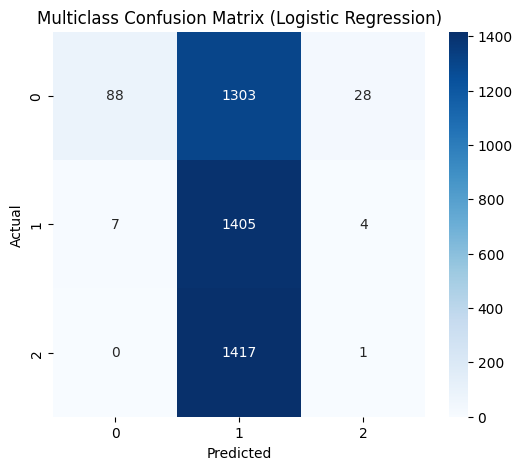

              precision    recall  f1-score   support

      Low Tc       0.93      0.06      0.12      1419
      Mid Tc       0.34      0.99      0.51      1416
     High Tc       0.03      0.00      0.00      1418

    accuracy                           0.35      4253
   macro avg       0.43      0.35      0.21      4253
weighted avg       0.43      0.35      0.21      4253



In [35]:
from sklearn.metrics import confusion_matrix, classification_report

cm_mc = confusion_matrix(y_test_mc, y_pred_mc)

plt.figure(figsize=(6,5))
sns.heatmap(cm_mc, annot=True, fmt='d', cmap='Blues')
plt.title("Multiclass Confusion Matrix (Logistic Regression)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification report
print(classification_report(y_test_mc, y_pred_mc, target_names=["Low Tc", "Mid Tc", "High Tc"]))


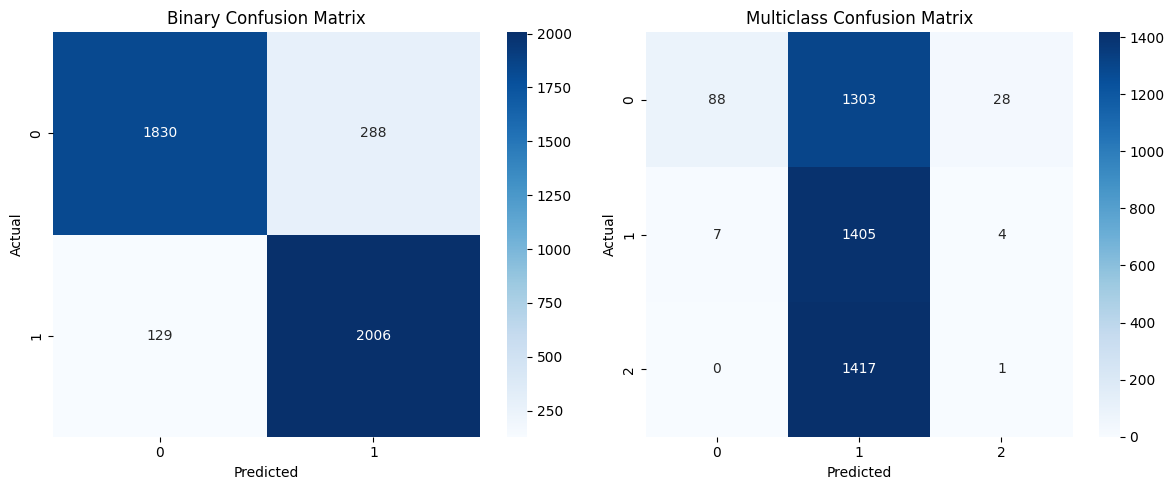

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title("Binary Confusion Matrix")
ax[0].set_xlabel("Predicted")
ax[0].set_ylabel("Actual")

sns.heatmap(confusion_matrix(y_test_mc, y_pred_mc), annot=True, fmt='d', cmap='Blues', ax=ax[1])
ax[1].set_title("Multiclass Confusion Matrix")
ax[1].set_xlabel("Predicted")
ax[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()
